# Giới thiệu
## Thông tin dataset
**Dataset**: HR Analytics: Job Change of Data Scientists  
**Source**: https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists

**Columns**:
- `enrollee_id` : Unique ID for candidate.
- `city`: City code.
- `city_ development _index`: Developement index of the city (scaled).
- `gender`: Gender of candidate
- `relevent_experience`: Relevant experience of candidate
- `enrolled_university`: Type of University course enrolled if any
- `education_level`: Education level of candidate
- `major_discipline`: Education major discipline of candidate
- `experience`: Candidate total experience in years
- `company_size`: No of employees in current employer's company
- `company_type`: Type of current employer
- `last_new_job`: Difference in years between previous job and current job
- `training_hours`: training hours completed
- `target`: 0 – Not looking for job change, 1 – Looking for a job change

## Đưa ra câu hỏi

1. Những yếu tố nào ảnh hưởng đến quyết định đổi công việc của ứng viên?
2. Đa số ứng viên trong tập dữ liệu này đến từ đâu (Thành phố nào)? Trình độ học vấn phổ biến là gì?
3. Tỷ lệ giữa người muốn nghỉ việc và người ở lại là bao nhiêu? Dữ liệu có bị mất cân bằng nghiêm trọng không?
4. Những cột dữ liệu nào bị thiếu nhiều nhất? Liệu việc thiếu này là ngẫu nhiên hay có quy luật?
5. Bài toán cần dự đoán điều gì? Ứng viên có đang tìm việc để rời công ty hiện tại hay không?

# Triển khai

## Setup đường dẫn

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  

## Import các thư viện và module

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import src.data_processing as dp
import src.visualization as viz


## Load dữ liệu

Dữ liệu sẽ được đọc từ file `aug_train.csv`. Các features được lưu vào header, toàn bộ dữ liệu sẽ được lưu vào data.

In [3]:
input_path = "../data/raw/aug_train.csv"

header = dp.read_header(input_path) 
data = dp.read_data(input_path) 
col_idx = {name: i for i, name in enumerate(header)} # Mỗi header tương ứng với 1 index để dễ truy cập  

print("Features:")
print(header)
print("\nData tương ứng:")
print(data[:5,:])

Features:
['enrollee_id' 'city' 'city_development_index' 'gender'
 'relevent_experience' 'enrolled_university' 'education_level'
 'major_discipline' 'experience' 'company_size' 'company_type'
 'last_new_job' 'training_hours' 'target']

Data tương ứng:
[['8949' 'city_103' '0.92' 'Male' 'Has relevent experience'
  'no_enrollment' 'Graduate' 'STEM' '>20' 'nan' 'nan' '1' '36' '1.0']
 ['29725' 'city_40' '0.7759999999999999' 'Male' 'No relevent experience'
  'no_enrollment' 'Graduate' 'STEM' '15' '50-99' 'Pvt Ltd' '>4' '47'
  '0.0']
 ['11561' 'city_21' '0.624' 'nan' 'No relevent experience'
  'Full time course' 'Graduate' 'STEM' '5' 'nan' 'nan' 'never' '83' '0.0']
 ['33241' 'city_115' '0.789' 'nan' 'No relevent experience' 'nan'
  'Graduate' 'Business Degree' '<1' 'nan' 'Pvt Ltd' 'never' '52' '1.0']
 ['666' 'city_162' '0.767' 'Male' 'Has relevent experience'
  'no_enrollment' 'Masters' 'STEM' '>20' '50-99' 'Funded Startup' '4' '8'
  '0.0']]


## Khám phá dữ liệu

### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [4]:
print("Số dòng:", data.shape[0])
print("Số cột:", data.shape[1])

Số dòng: 19158
Số cột: 14


### 5 dòng đầu của tập dữ liệu

In [5]:
print("Header:",header)
print("5 dòng đầu:")
print(data[:5])

Header: ['enrollee_id' 'city' 'city_development_index' 'gender'
 'relevent_experience' 'enrolled_university' 'education_level'
 'major_discipline' 'experience' 'company_size' 'company_type'
 'last_new_job' 'training_hours' 'target']
5 dòng đầu:
[['8949' 'city_103' '0.92' 'Male' 'Has relevent experience'
  'no_enrollment' 'Graduate' 'STEM' '>20' 'nan' 'nan' '1' '36' '1.0']
 ['29725' 'city_40' '0.7759999999999999' 'Male' 'No relevent experience'
  'no_enrollment' 'Graduate' 'STEM' '15' '50-99' 'Pvt Ltd' '>4' '47'
  '0.0']
 ['11561' 'city_21' '0.624' 'nan' 'No relevent experience'
  'Full time course' 'Graduate' 'STEM' '5' 'nan' 'nan' 'never' '83' '0.0']
 ['33241' 'city_115' '0.789' 'nan' 'No relevent experience' 'nan'
  'Graduate' 'Business Degree' '<1' 'nan' 'Pvt Ltd' 'never' '52' '1.0']
 ['666' 'city_162' '0.767' 'Male' 'Has relevent experience'
  'no_enrollment' 'Masters' 'STEM' '>20' '50-99' 'Funded Startup' '4' '8'
  '0.0']]


### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Mỗi dòng ứng với thông tin cơ bản của một ứng viên. Các dòng đều có ý nghĩa giống nhau.

### Dữ liệu có các dòng bị lặp không?

Để coi dữ liệu có bị lặp hay không ta hãy thử xét cột `enrollee_id` xem các giá trị duy nhất của cột này có bằng số dòng dữ liệu hay không.

In [6]:
n_enrollees = np.unique(data[:,col_idx['enrollee_id']]).size
row = data.shape[0]
if row == n_enrollees:
    print("Dữ liệu không tồn tại dòng nào bị lặp")
else:
    print("Dữ liệu có tồn tại dòng bị lặp")
    

Dữ liệu không tồn tại dòng nào bị lặp


### Phân tích các cột

#### Thông tin của các cột (Kiểu dữ liệu,...)

In [7]:
dp.np_info(data, header)

Rows: 19158, Columns: 14
------------------------------------------------
 #  Column                  Non-Null  Dtype
--- ------------------------  -----
0   enrollee_id              19158    int64
1   city                     19158    object
2   city_development_index   19158    float64
3   gender                   14650    object
4   relevent_experience      19158    object
5   enrolled_university      18772    object
6   education_level          18698    object
7   major_discipline         16345    object
8   experience               19093    object
9   company_size             13220    object
10  company_type             13018    object
11  last_new_job             18735    object
12  training_hours           19158    int64
13  target                   19158    int64
------------------------------------------------


#### Giá trị của từng cột là gì?

In [8]:
for h in header:
    print(f"Cột {h}")
    print(np.unique(data[:, col_idx[h]]))

Cột enrollee_id
['1' '10' '10000' ... '9992' '9995' '9998']
Cột city
['city_1' 'city_10' 'city_100' 'city_101' 'city_102' 'city_103' 'city_104'
 'city_105' 'city_106' 'city_107' 'city_109' 'city_11' 'city_111'
 'city_114' 'city_115' 'city_116' 'city_117' 'city_118' 'city_12'
 'city_120' 'city_121' 'city_123' 'city_126' 'city_127' 'city_128'
 'city_129' 'city_13' 'city_131' 'city_133' 'city_134' 'city_136'
 'city_138' 'city_139' 'city_14' 'city_140' 'city_141' 'city_142'
 'city_143' 'city_144' 'city_145' 'city_146' 'city_149' 'city_150'
 'city_152' 'city_155' 'city_157' 'city_158' 'city_159' 'city_16'
 'city_160' 'city_162' 'city_165' 'city_166' 'city_167' 'city_171'
 'city_173' 'city_175' 'city_176' 'city_179' 'city_18' 'city_180'
 'city_19' 'city_2' 'city_20' 'city_21' 'city_23' 'city_24' 'city_25'
 'city_26' 'city_27' 'city_28' 'city_30' 'city_31' 'city_33' 'city_36'
 'city_37' 'city_39' 'city_40' 'city_41' 'city_42' 'city_43' 'city_44'
 'city_45' 'city_46' 'city_48' 'city_50' 'city_

#### Có cột nào có giá trị thiếu không?

In [23]:
print("=" * 50)
print("THỐNG KÊ GIÁ TRỊ THIẾU")
print("=" * 50)

# Tạo header cho bảng
print(f"{'CỘT':<25} {'SỐ LƯỢNG':<12} {'TỶ LỆ (%)':<12}")
print("-" * 44)

for h in header:
    col_data = data[:, col_idx[h]]
    missing_count = len(col_data[col_data == 'nan'])
    missing_percentage = (missing_count / data.shape[0]) * 100
    
    print(f"{h:<25} {missing_count:<12} {missing_percentage:<12.2f}")

print("-" * 44)
total_rows = data.shape[0]
print(f"{'TỔNG SỐ DÒNG':<25} {total_rows:<12}")
print("=" * 50)

THỐNG KÊ GIÁ TRỊ THIẾU
CỘT                       SỐ LƯỢNG     TỶ LỆ (%)   
--------------------------------------------
enrollee_id               0            0.00        
city                      0            0.00        
city_development_index    0            0.00        
gender                    4508         23.53       
relevent_experience       0            0.00        
enrolled_university       386          2.01        
education_level           460          2.40        
major_discipline          2813         14.68       
experience                65           0.34        
company_size              5938         30.99       
company_type              6140         32.05       
last_new_job              423          2.21        
training_hours            0            0.00        
target                    0            0.00        
--------------------------------------------
TỔNG SỐ DÒNG              19158       


### Biểu đồ thể hiện các giá trị thiếu

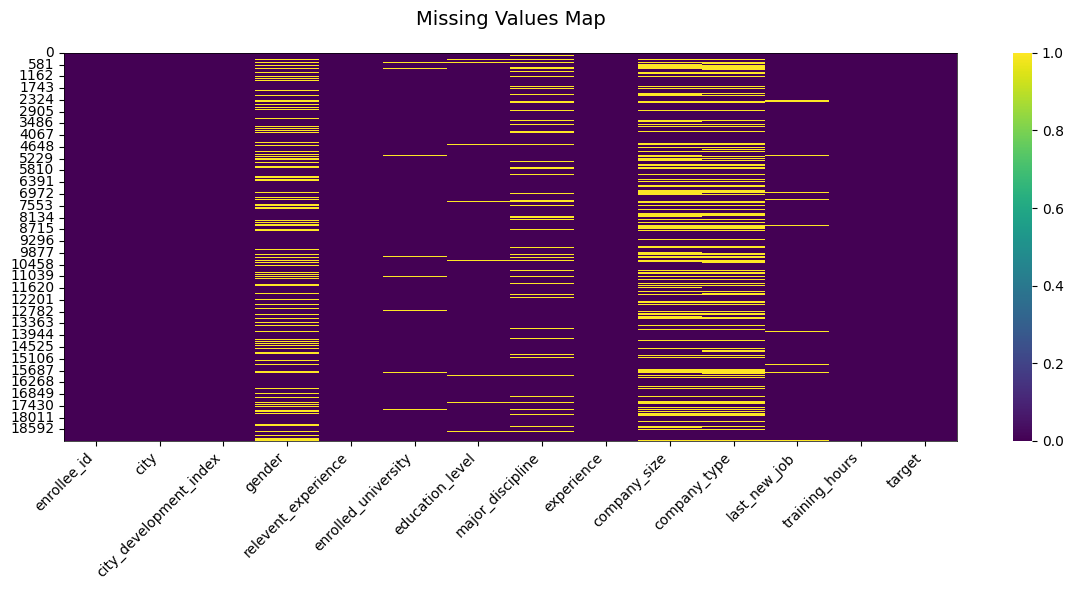

In [10]:
# Lấy danh sách tên cột theo đúng thứ tự index
sorted_cols = sorted(col_idx, key=col_idx.get)
viz.plot_missing_heatmap(data, col_names=sorted_cols)

**Nhận xét:**  
1. Về Missing Values:
- Nhóm thiếu nghiệm trọng (>30%):`company_type` và `company_size`
- Nhóm thiếu trung bình (10% - 25%): `gender` và `major_discipline`
- Nhóm thiếu ít (< 3%): `enrolled_university`, `education_level`, `last_new_job`, `experience`  
Chúng ta thay thế giá trị thiếu bằng cách thêm 'Unknown' vào các cột chứa giá trị là chuỗi, còn các cột chứa giá trị số thì nên thay bằng median.
2. Về kiểu dữ liệu
Có nhiều cột đang ở dạng object (chuỗi) nhưng bản chất lại mang ý nghĩa thứ tự hoặc số học, cần phải chuyển đổi để đưa vào mô hình:
- `experience`: Đang là object vì chứa các giá trị như '>20', '<1'. Cần xử lý các ký tự >, < để chuyển sang dạng số.
- `last_new_job`: Đang là object vì chứa các giá trị như '>4', 'never'. Cần xử lý và chuyển sang dạng số.
- `company_size`: Đang là object vì chứa các giá trị như '50-99', '<10',v.v. Cần xử lý và chuyển sang dạng số.
3. Cột nào không cần thiết
- `enrollee_id`: Đây là giá trị duy nhất cho mỗi người, chỉ là định danh. Nếu đưa vào, model (đặc biệt là Decision Tree/Random Forest) có thể sẽ cố "học thuộc lòng" mã số này để dự đoán kết quả. Điều này dẫn đến Overfitting (quá khớp) – model đúng 100% trên tập train nhưng sai bét trên thực tế, nên xóa đi.
<!-- - `city`: đã có cột `city_development_index` (Chỉ số phát triển). Thường thì chỉ số này đã bao hàm ý nghĩa kinh tế/xã hội của thành phố đó rồi. Cột `city` có rất nhiều giá trị khác nhau. Nếu dùng One-Hot Encoding, nó sẽ đẻ ra hàng trăm cột mới, làm model chạy chậm và kém hiệu quả. -->
- `gender`: Trong tuyển dụng, lý tưởng nhất là không phân biệt giới tính. Ngoài ra, cột này thiếu dữ liệu rất nhiều (23%). Dễ bị bias, nên xóa

### Thống kê cơ bản

In [11]:
dp.np_describe(data, header)

             enrollee_id   city_development_index  training_hours   target  
count                19158                   19158           19158     19158
mean          16875.358179                0.828848       65.366896  0.249348
std            9616.292592                0.123362       60.058462  0.432647
min                      1                   0.448               1         0
25%                8554.25                    0.74              23         0
50%                16982.5                   0.903              47         0
75%               25169.75                    0.92              88         0
max                  33380                   0.949             336         1


**Nhận xét:**
1. Tổng quan về dữ liệu:
- Số lượng mẫu: có 19.158 dòng dữ liệu.
- Dữ liệu sạch (cơ bản): cả 4 cột đều có số lượng count bằng nhau (19.158), cho thấy không có giá trị bị thiếu (null/missing values) trong các cột số này
2. Phân tích chi tiết:
- Biến mục tiêu (target) - Quan trọng nhất: đây là biến phân loại (0: Không đổi việc, 1: Có ý định đổi việc)
    + Có khoảng 24.9% ứng viên có ý định chuyển việc.
    + Có khoảng 75.1% ứng viên không có ý định chuyển việc.
    + Đây là một bộ dữ liệu mất cân bằng (imbalanced dataset). Khi xây dựng mô hình Machine Learning (như Classification), bạn sẽ cần lưu ý các kỹ thuật xử lý mất cân bằng mẫu (như SMOTE, class weights) hoặc chọn metric đánh giá phù hợp (như F1-Score, AUC thay vì Accuracy).
- Chỉ số phát triển thành phố (city_development_index):
    + Dải giá trị: Từ 0.448 đến 0.949.
    + So sánh Mean (0.828) và Median (50% - 0.903): Median cao hơn đáng kể so với Mean, điều này cho thấy phân phối dữ liệu bị lệch trái (Left-skewed/Negative skew).
- Giờ đào tạo (training_hours):
    + Dải giá trị: Rất rộng, từ 1 giờ đến 336 giờ.
    + So sánh Mean (65.36) và Median (50% - 47): Mean lớn hơn Median, điều này cho thấy phân phối dữ liệu bị lệch phải (Right-skewed/Positive skew).
- Mã ứng viên (enrollee_id): Các chỉ số thống kê như Mean, Std, Min, Max ở đây không có ý nghĩa phân tích, cột này đã phân tích từ trước là cần được loại bỏ.

### Trực quan hóa các phân phối

#### Phân phối biến mục tiêu (target)

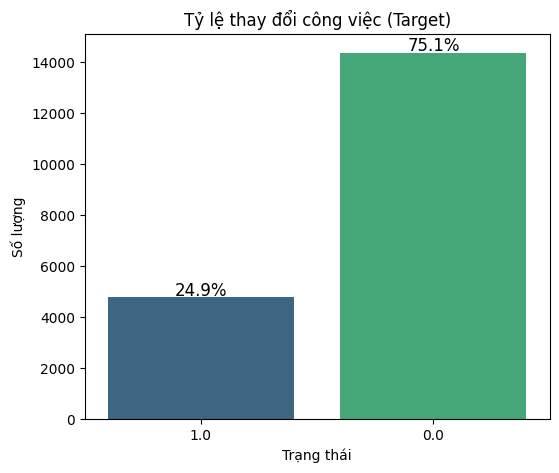

In [12]:
# 1. Lấy cột target từ mảng data
target_col = data[:, col_idx['target']]

plt.figure(figsize=(6, 5))

# 2. Truyền trực tiếp mảng numpy vào tham số x
ax = sns.countplot(x=target_col, hue=target_col, legend=False, palette='viridis')

# 3. Tính phần trăm (Dùng len(data) thay vì len(df))
total = len(data)
for p in ax.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height / total)
    ax.text(p.get_x() + p.get_width() / 2., height + 50,
            percentage, ha="center", fontsize=12)

plt.title('Tỷ lệ thay đổi công việc (Target)')
plt.xlabel('Trạng thái')
plt.ylabel('Số lượng')
plt.show()

**Nhận xét**:
- Mất cân bằng dữ liệu (Imbalanced Data): Tỷ lệ nhóm 0 (Không đổi việc) chiếm khoảng 75%, trong khi nhóm 1 (Đổi việc) chỉ chiếm 25%.  
- Kết luận: Mô hình sẽ có xu hướng dự đoán thiên về nhóm 0. Cần lưu ý sử dụng các kỹ thuật như SMOTE (để sinh thêm mẫu nhóm 1) hoặc sử dụng tham số class_weight='balanced' trong các thuật toán Machine Learning sau này. Metric đánh giá nên dùng F1-Score hoặc AUC thay vì Accuracy.

#### Phân phối biến định lượng (Numerical Features)

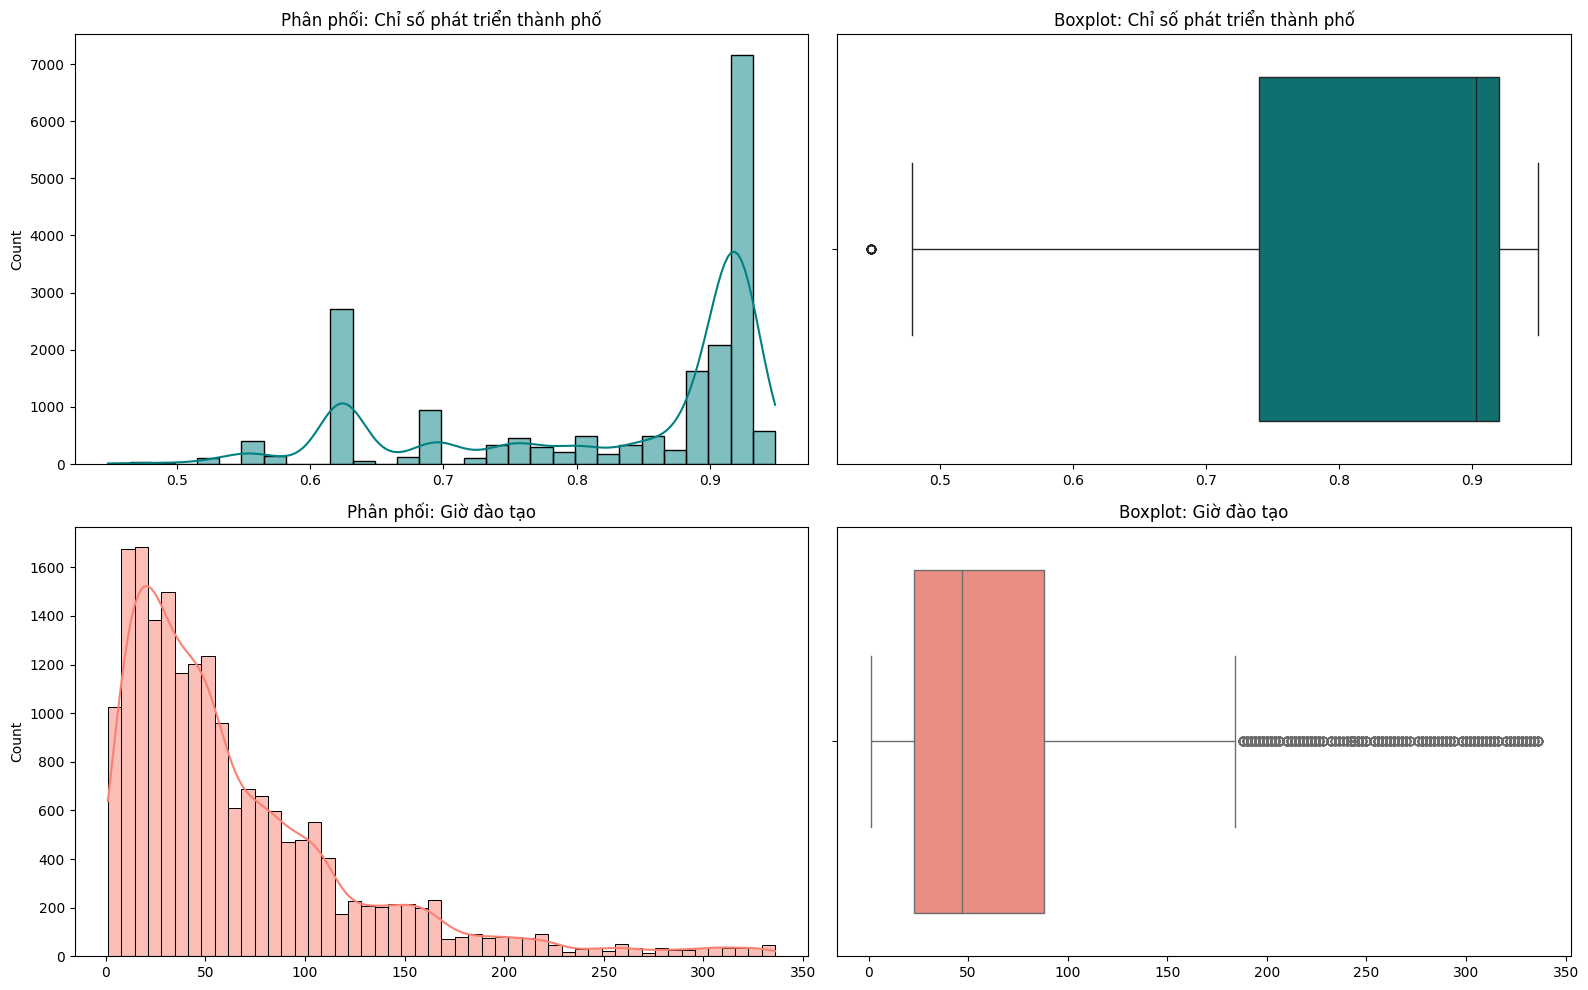

In [13]:
# Lấy dữ liệu và ép kiểu sang số thực (float)
# Cần xử lý cẩn thận nếu dữ liệu có giá trị rỗng/chuỗi lạ (nhưng ở đây giả sử data đã sạch hoặc chấp nhận lỗi)
cdi_col = data[:, col_idx['city_development_index']].astype(float)
training_hours_col = data[:, col_idx['training_hours']].astype(float)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# --- Hàng 1: City Development Index ---
# Histogram
sns.histplot(x=cdi_col, bins=30, kde=True, ax=axes[0, 0], color='teal')
axes[0, 0].set_title('Phân phối: Chỉ số phát triển thành phố')

# Boxplot
sns.boxplot(x=cdi_col, ax=axes[0, 1], color='teal')
axes[0, 1].set_title('Boxplot: Chỉ số phát triển thành phố')

# --- Hàng 2: Training Hours ---
# Histogram
sns.histplot(x=training_hours_col, bins=50, kde=True, ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('Phân phối: Giờ đào tạo')

# Boxplot
sns.boxplot(x=training_hours_col, ax=axes[1, 1], color='salmon')
axes[1, 1].set_title('Boxplot: Giờ đào tạo')

plt.tight_layout()
plt.show()

**Nhận xét:**
- `city_development_index` (CDI): 
    + Phân phối có dạng Lệch trái (Left-skewed)
    + Phần lớn ứng viên đến từ các thành phố rất phát triển (CDI > 0.9). Có một đỉnh phụ nhỏ ở khoảng 0.6. Điều này gợi ý rằng nhân lực Data Science tập trung chủ yếu ở các đô thị lớn.
- `training_hours`:
    + Phân phối Lệch phải (Right-skewed) nghiêm trọng.
    + Outliers (Giá trị ngoại lai): Biểu đồ Boxplot cho thấy rất nhiều điểm nằm ngoài râu (whiskers) phía bên phải (trên 200 giờ).
    + Kết luận: Đa số mọi người chỉ dành khoảng 20-50 giờ đào tạo. Những người học trên 200 giờ là nhóm thiểu số đặc biệt. Cần cân nhắc sử dụng biến đổi log (Log Transformation) để làm "mượt" phân phối này trước khi đưa vào mô hình.

#### Phân phối biến phân loại (Categorical Features)

##### Các biến phân loại về Hồ sơ công việc & Học vấn
Gồm: `relevent_experience`, `enrolled_university`, `education_level`, `major_discipline`

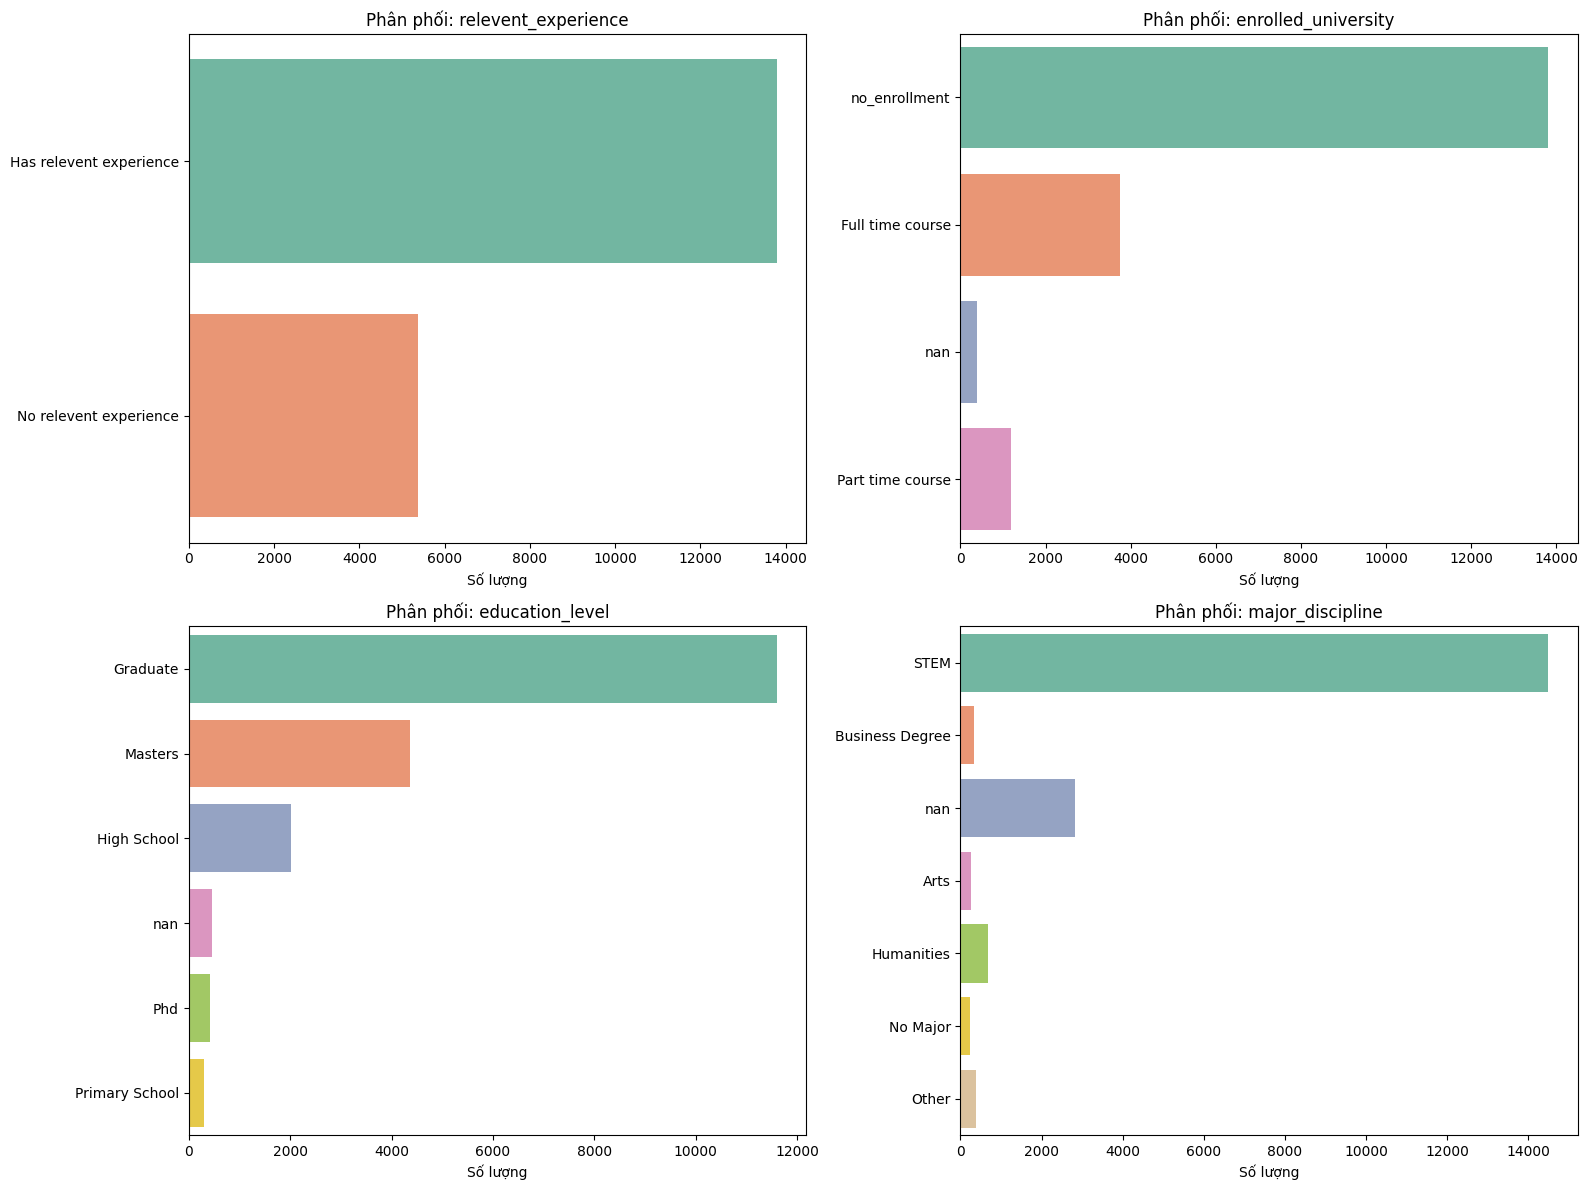

In [14]:
# Danh sách các cột cần vẽ
cols_profile = ['relevent_experience', 'enrolled_university', 'education_level', 'major_discipline']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten() # Làm phẳng mảng axes để dễ truy cập theo index 0,1,2,3

for i, col_name in enumerate(cols_profile):
    # Lấy dữ liệu cột
    col_data = data[:, col_idx[col_name]]
    
    # Vẽ biểu đồ
    # Lưu ý: Dữ liệu thô có thể có giá trị 'nan' (dạng chuỗi hoặc rỗng), countplot sẽ hiển thị nó luôn
    sns.countplot(y=col_data, hue=col_data, legend=False, ax=axes[i], palette='Set2')
    
    axes[i].set_title(f'Phân phối: {col_name}')
    axes[i].set_xlabel('Số lượng')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

**Nhận xét:**
- `relevent_experience`: Đa số ứng viên (khoảng >70%) đã có kinh nghiệm liên quan (Has relevent experience). Đây là một tín hiệu tốt về chất lượng ứng viên.
- `enrolled_university`: Phần lớn ứng viên hiện không theo học trường đại học nào (no_enrollment). Nhóm Full time course đứng thứ 2.
- `education_level`: Đa số ứng viên là cử nhân Đại học (Graduate), sau đó là Thạc sĩ (Masters). Nhóm Tiến sĩ (Phd) và Trung học (High School) chiếm tỷ lệ rất nhỏ.
- `major_discipline`: Ngành STEM áp đảo hoàn toàn. Lưu ý cột này có khá nhiều giá trị thiếu (nếu trong raw data nó là chuỗi rỗng hoặc nan, biểu đồ sẽ không hiện hoặc hiện thanh riêng, cần chú ý).

##### Các biến phân loại về Công ty & Kinh nghiệm (Có tính thứ tự)
Gồm: `experience`, `company_size`, `company_type`, `last_new_job`

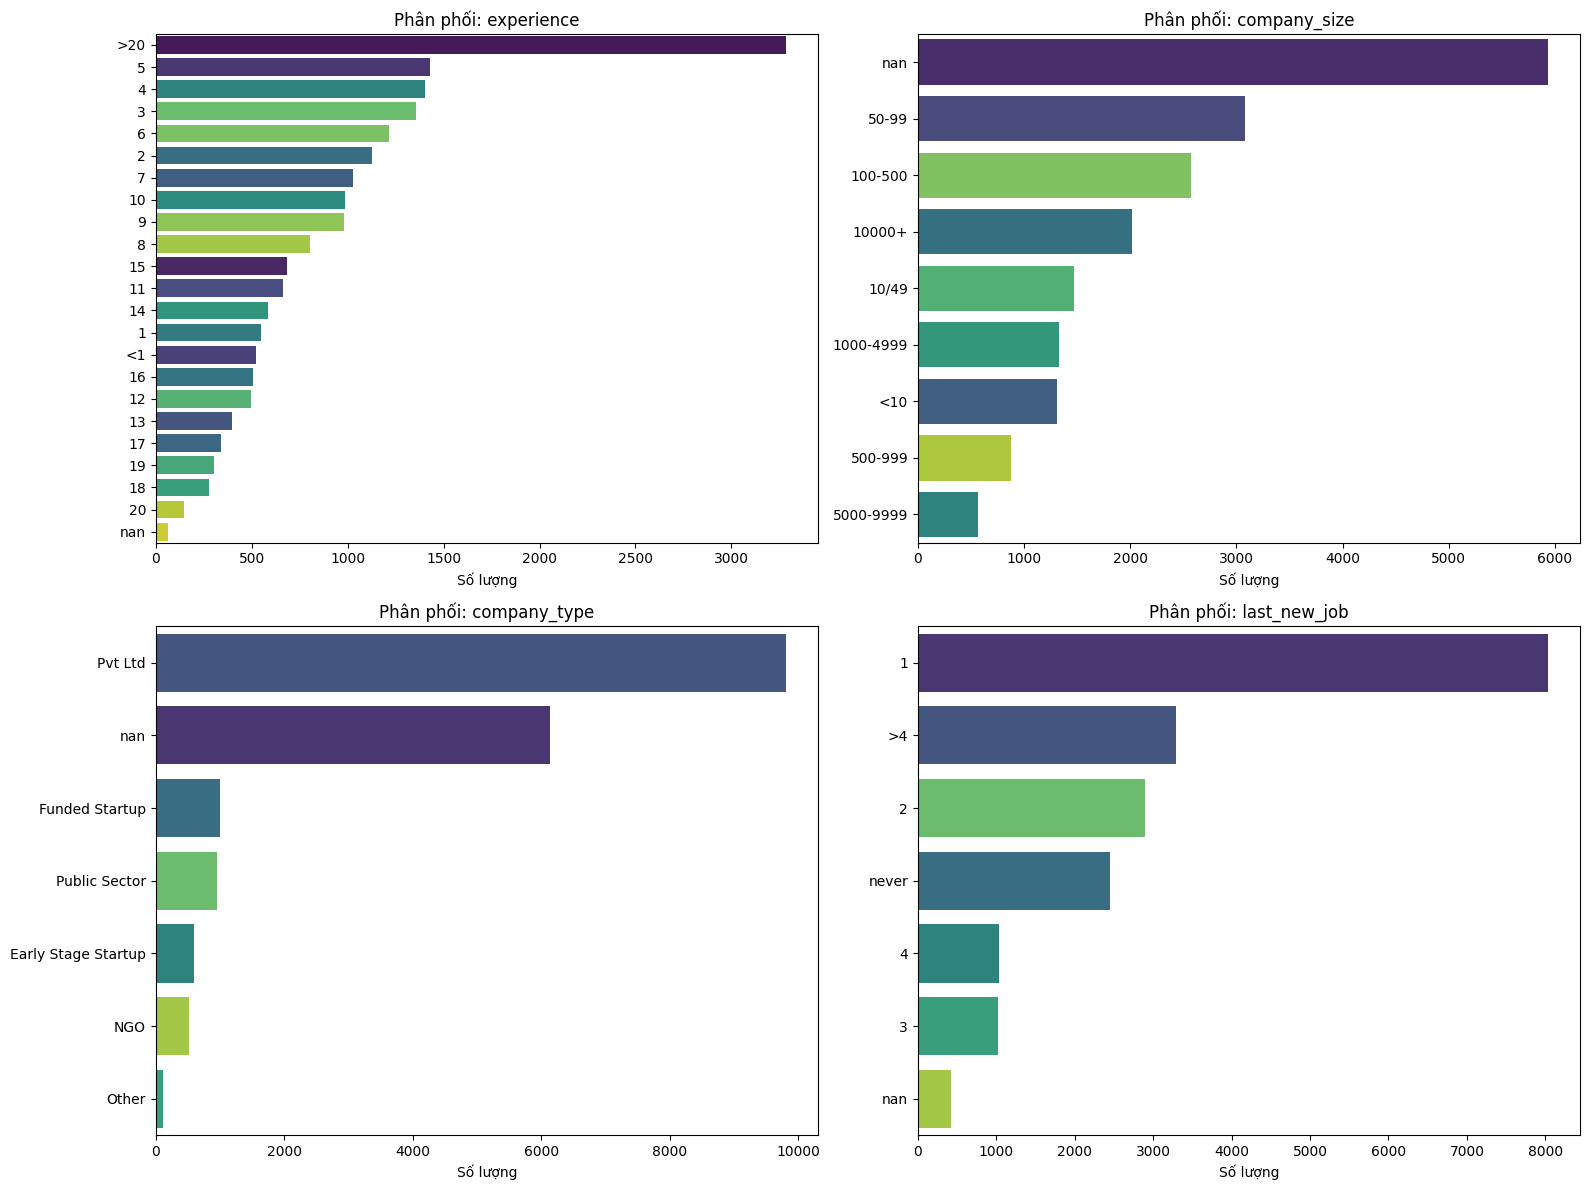

In [15]:
cols_work = ['experience', 'company_size', 'company_type', 'last_new_job']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, col_name in enumerate(cols_work):
    col_data = data[:, col_idx[col_name]]
    
    # Tinh chỉnh: Vì experience có nhiều giá trị, ta nên sắp xếp theo thứ tự xuất hiện nhiều nhất để dễ nhìn
    # Dùng numpy để đếm và lấy index sắp xếp
    unique, counts = np.unique(col_data, return_counts=True)
    sorted_idx = np.argsort(counts)[::-1] # Sắp xếp giảm dần
    order_labels = unique[sorted_idx]
    
    sns.countplot(y=col_data, hue=col_data, legend=False, ax=axes[i], 
                  order=order_labels, palette='viridis') # Thêm tham số order
    
    axes[i].set_title(f'Phân phối: {col_name}')
    axes[i].set_xlabel('Số lượng')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

**Nhận xét:**
- `experience`: Giá trị xuất hiện nhiều nhất là >20 (trên 20 năm kinh nghiệm). Các mức kinh nghiệm khác (3, 4, 5 năm) phân phối khá đều. Điều này cho thấy tập dữ liệu này chứa rất nhiều chuyên gia lão làng ("senior").
- `company_size`: Các công ty quy mô nhỏ (50-99 nhân viên) chiếm tỷ trọng lớn nhất trong các giá trị quan sát được. Lưu ý: Cột này thiếu dữ liệu rất nhiều, biểu đồ này chỉ phản ánh trên tập dữ liệu CÓ thông tin.
- `company_type`: Loại hình Pvt Ltd (Công ty tư nhân trách nhiệm hữu hạn) chiếm đa số áp đảo. Các loại hình như NGO hay Public Sector rất ít.
- `last_new_job` (Khoảng cách đổi việc): Phổ biến nhất là 1 (1 năm giữa 2 lần đổi việc) và >4 (trên 4 năm).

##### Biến `city` (Xử lý đặc biệt)
Cột `city` có rất nhiều mã thành phố (ví dụ city_103, city_21...). Nếu vẽ hết sẽ bị rối. Ta chỉ nên vẽ Top 15 thành phố phổ biến nhất.

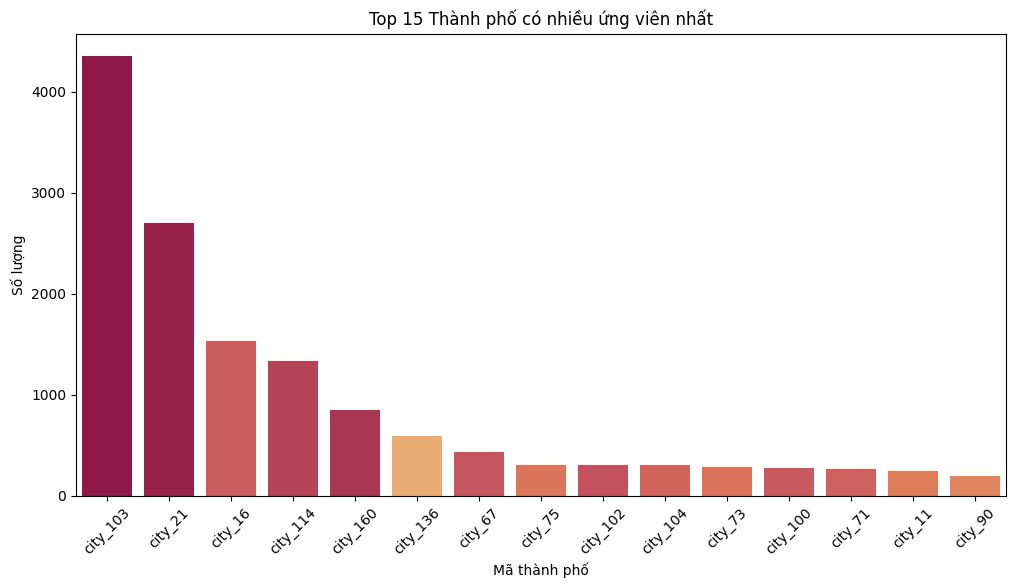

In [16]:
# Lấy dữ liệu cột city
city_col = data[:, col_idx['city']]

# Dùng Numpy để đếm tần suất
unique_cities, counts = np.unique(city_col, return_counts=True)

# Sắp xếp giảm dần theo số lượng
sorted_indices = np.argsort(counts)[::-1]
top_10_cities = unique_cities[sorted_indices][:15] # Lấy top 15

plt.figure(figsize=(12, 6))
# Chỉ lọc ra các dòng thuộc top 15 thành phố này để vẽ (Hoặc truyền thứ tự vào order)
sns.countplot(x=city_col, order=top_10_cities, hue=city_col, legend=False, palette='Spectral')

plt.title('Top 15 Thành phố có nhiều ứng viên nhất')
plt.xticks(rotation=45) # Xoay nhãn trục X cho dễ đọc
plt.xlabel('Mã thành phố')
plt.ylabel('Số lượng')
plt.show()

**Nhận xét:**
- Sự tập trung cục bộ: Có một thành phố (cột cao nhất bên trái, khả năng là city_103) chiếm số lượng áp đảo so với phần còn lại.
- Top 3-4 thành phố: Đóng góp phần lớn lượng dữ liệu. Các thành phố phía sau có số lượng ứng viên rất thấp (Long tail).
- Hệ quả: Khi mô hình hóa, nếu sử dụng biến city, mô hình sẽ học rất tốt ở các thành phố lớn này nhưng có thể sai lệch lớn ở các thành phố nhỏ lẻ.

### Phân tích tính tương quan của các cột

#### Tương quan giữa các biến số (Correlation Heatmap)
Chúng ta sẽ xem xét mối quan hệ giữa 3 biến số quan trọng nhất: `city_development_index`, `training_hours`, và `target`.

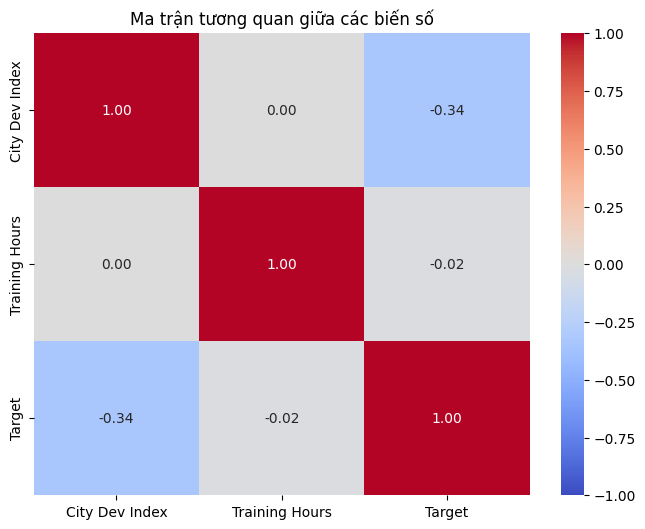

In [17]:

cdi = data[:, col_idx['city_development_index']].astype(float)
hours = data[:, col_idx['training_hours']].astype(float)
target = data[:, col_idx['target']].astype(float)


numerical_data = np.column_stack((cdi, hours, target))

# Tính ma trận tương quan (Pearson Correlation)
corr_matrix = np.corrcoef(numerical_data, rowvar=False)

# Vẽ Heatmap
plt.figure(figsize=(8, 6))
labels = ['City Dev Index', 'Training Hours', 'Target']

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=labels, yticklabels=labels, vmin=-1, vmax=1)

plt.title('Ma trận tương quan giữa các biến số')
plt.show()

**Nhận xét:**
- City Dev Index vs Target (Hệ số âm, ví dụ -0.34): tương quan nghịch (Negative Correlation). Khi chỉ số phát triển thành phố càng cao, khả năng ứng viên đổi việc càng thấp.
- Training Hours vs Target (Hệ số gần 0, ví dụ -0.02): không có tương quan (No Correlation). Thời gian đào tạo nhiều hay ít không ảnh hưởng đến việc họ có muốn đổi việc hay không. Việc dành 100h hay 10h để học không quyết định việc họ sẽ nhảy việc.


#### Mối quan hệ giữa Biến phân loại và Target

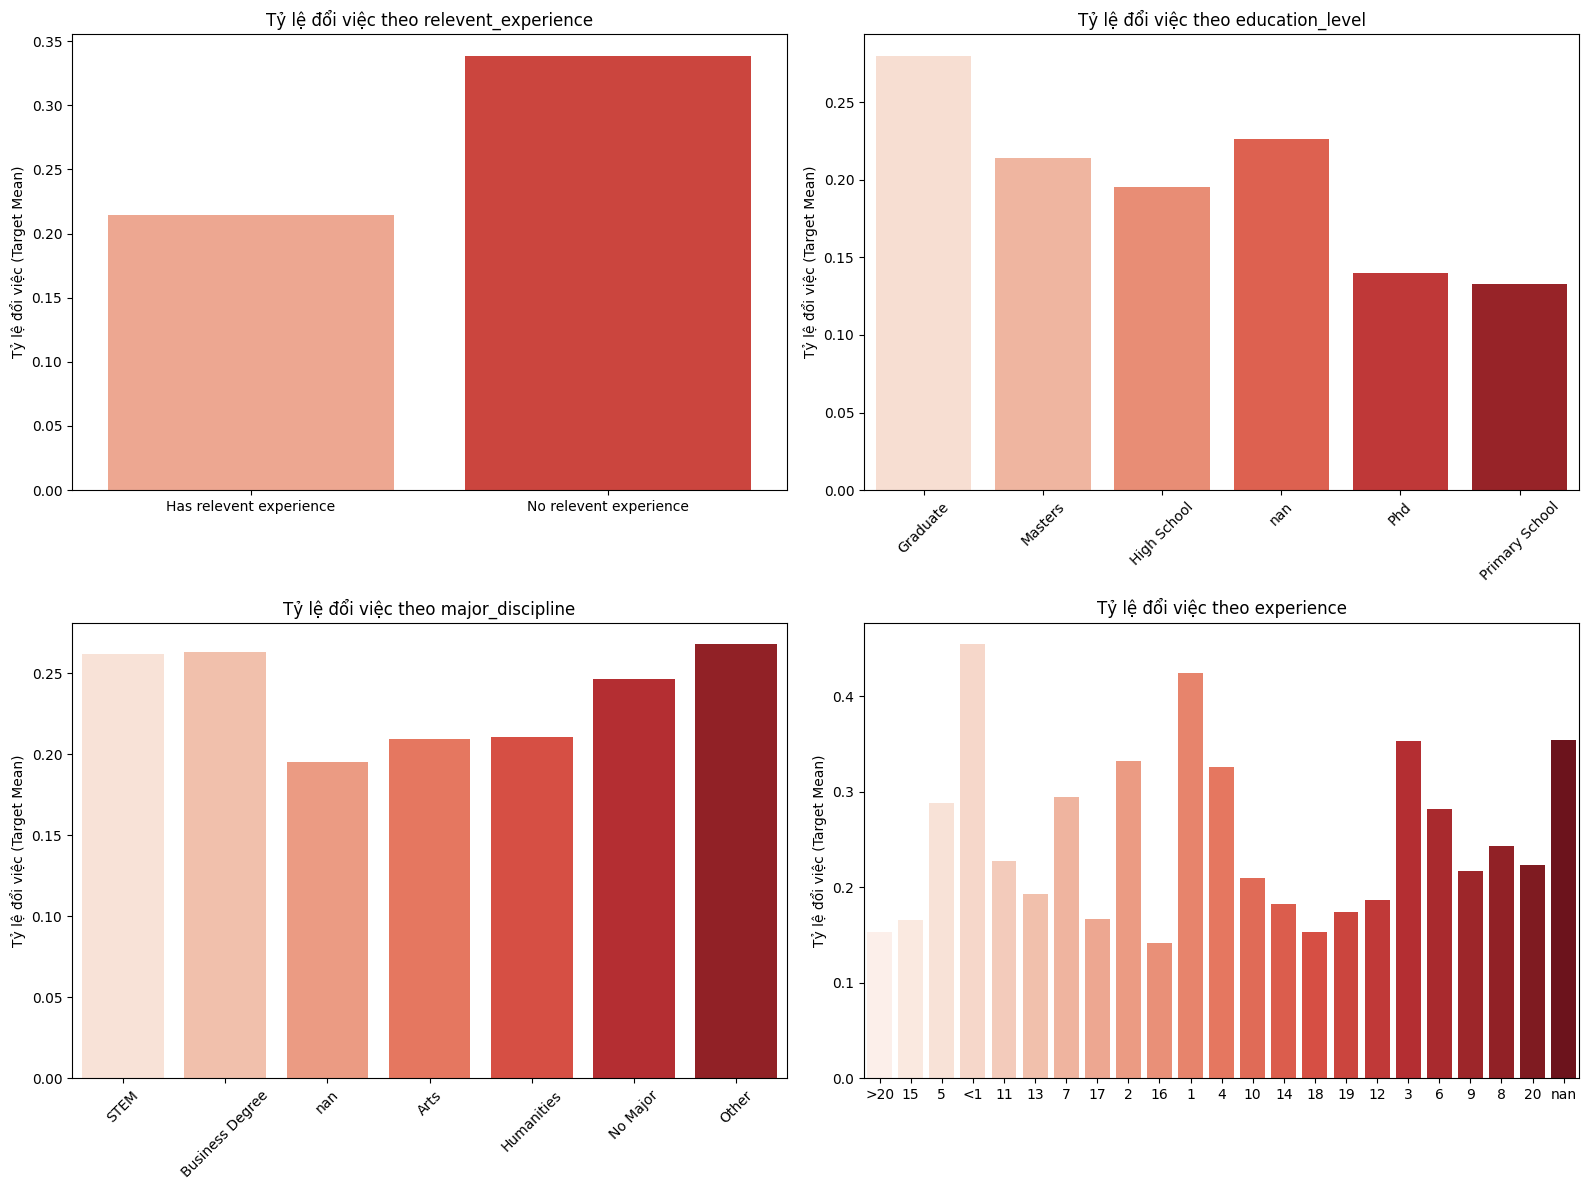

In [18]:
# Chọn các cột phân loại cần soi xét
cols_to_analyze = ['relevent_experience', 'education_level', 'major_discipline', 'experience']
target = data[:, col_idx['target']].astype(float) # Target dạng số để tính trung bình

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, col_name in enumerate(cols_to_analyze):
    col_data = data[:, col_idx[col_name]]
    
    # Vẽ biểu đồ Barplot: Trục Y sẽ tự động tính Mean của Target (Tỷ lệ đổi việc)
    # ci=None để tắt thanh sai số cho đỡ rối
    sns.barplot(x=col_data, y=target, hue=col_data, ax=axes[i], palette='Reds', errorbar=None)
    
    axes[i].set_title(f'Tỷ lệ đổi việc theo {col_name}')
    axes[i].set_ylabel('Tỷ lệ đổi việc (Target Mean)')
    axes[i].set_xlabel('')
    
    # Xoay chữ trục X nếu quá dài (ví dụ education_level)
    if col_name in ['major_discipline', 'education_level']:
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Nhận xét:**
1. `relevent_experience` (Kinh nghiệm liên quan):
- Nhóm "Has relevent experience" có tỷ lệ đổi việc thấp hơn nhóm "No relevent experience".
- Lý do: Người đã có kinh nghiệm thường ổn định hơn, trong khi người mới thường loay hoay tìm kiếm cơ hội phù hợp.
2. `education_level` (Học vấn):
- Nhóm Graduate (Cử nhân) có xu hướng đổi việc cao nhất.
- Nhóm Phd (Tiến sĩ) và Primary School (Tiểu học) có tỷ lệ đổi việc thấp hơn.
3. `major_discipline` (Chuyên ngành):
- Các cột chiều cao khá tương đồng nhau.
- Kết luận: Chuyên ngành học (STEM hay Art hay Business) không ảnh hưởng nhiều đến quyết định nhảy việc. Điều này gợi ý rằng biến này có thể không quan trọng lắm cho mô hình (Feature Importance thấp).
4. `experience` (Số năm kinh nghiệm): thấy cột <1 cao và cột >20 thấp cho thấy kinh nghiệm càng ít, tỷ lệ nhảy việc càng cao.

# Tổng kết và Kết luận

1. Về Chất lượng Dữ liệu
- Missing Values:
    + Hai cột `company_type` và `company_size` thiếu dữ liệu nghiêm trọng (~30%)
    + Các cột khác `(gender, major_discipline...)` thiếu ở mức trung bình và thấp (< 2% - 15%).

- Data Types: nhiều biến định lượng (numerical) đang bị lưu dưới dạng chuỗi (object) như `experience` ('>20', '<1') và `last_new_job`. Cần phải chuyển đổi về dạng số để mô hình hiểu được tính thứ bậc.
- Dữ liệu rác/thừa: Cột enrollee_id là mã định danh vô nghĩa trong mô hình hóa.

2. Về Đặc điểm Phân phối
- Mất cân bằng dữ liệu (Class Imbalance): Biến mục tiêu target bị lệch đáng kể (75% không đổi việc vs 25% đổi việc). Đây là thách thức chính cho độ chính xác của mô hình.
- Biến thiên dữ liệu (Variance):
    + `city_development_index`: Phân phối lệch trái (tập trung ở mức cao > 0.9).
    + `training_hours`: Phân phối lệch phải với rất nhiều Outliers (giá trị ngoại lai) ở mức cao (> 200 giờ)

3. Về Các yếu tố ảnh hưởng
Dựa trên phân tích tương quan và trực quan hóa, chân dung của người dễ đổi việc (Target = 1) là:
- Đang sống ở thành phố kém phát triển (CDI thấp): Đây là yếu tố dự báo mạnh nhất (Tương quan nghịch rõ rệt).
- Kinh nghiệm làm việc ít: Người mới (Fresher) có xu hướng nhảy việc cao hơn các chuyên gia (> 20 năm).
- Học vấn: Nhóm Cử nhân (Graduate) nhảy việc nhiều hơn nhóm Thạc sĩ/Tiến sĩ.
- Ít quan trọng: Chuyên ngành (major_discipline) và Giờ đào tạo (training_hours) không cho thấy sự khác biệt quá lớn giữa hai nhóm.